### Analysis description
Here we aim at drawing all pycortex flatmaps, create static webgl, and plot inflated brain maps.<br/>
This analysis is ran first with _task = 'FullScreen'_ to determine and _save_svg_ = True.<br/>

In [1]:
# Imports
import os
import numpy as np
import nibabel as nb
import shutil
import warnings
import cortex
import re
import time
import matplotlib.pyplot as plt
from pycortex_utils import draw_cortex
from pathlib import Path
warnings.filterwarnings('ignore')

# Define parameters
subjects = ['sub-001','sub-002','sub-003','sub-004',
            'sub-005','sub-006','sub-007','sub-008']

subjects = ['sub-001']

tasks = ['FullScreenAttendFix', 
         'FullScreenAttendBar',
         'FullScreen',
         'GazeCenterAttendFix_optim',
         'GazeLeftAttendFix_optim',
         'GazeRightAttendFix_optim', 
         'GazeCenterAttendBar_optim',
         'GazeLeftAttendBar_optim',
         'GazeRightAttendBar_optim',
        ]

# Define folders
base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)
pycortex_dir = "{}/cortex".format(pp_dir)

# Plot parameters
cmap_polar, cmap_uni, cmap_ecc_size, cmap_2d, cmap_ref_index, roi = 'hsv', 'Reds', 'Spectral', 'PU_RdBu_covar_alpha', 'RdBu_r', 'rois_colors'
save_svg = False
xfm_name = 'identity.fmriprep'
alpha_range = [0, 0.4]
r2_range = [0, 1]
r2_2d_range = [0, 0.4]
ecc_range = [0, 10]
size_range = [0, 10]
rois_range = [0, 14]
ref_index_range = [-0.6,0.6]
col_offset = 1.0/14.0
cmap_steps = 255
recache = False
inflated_maps_names = ['FullScreen_polar','FullScreen_ecc','FullScreen_attcmp','AttendBar_ref_index','AttendFix_ref_index']

In [2]:
# Write pycortex config file
pycortex_db = "{}/db/".format(pycortex_dir)
pycortex_cm = "{}/colormaps/".format(pycortex_dir)
pycortex_config_file  = cortex.options.usercfg
pycortex_config_file_new = pycortex_config_file[:-4] + '_new.cfg'
pycortex_config_file_old = pycortex_config_file[:-4] + '_old.cfg'

Path(pycortex_config_file_new).touch()
with open(pycortex_config_file, 'r') as fileIn:
    with open(pycortex_config_file_new, 'w') as fileOut:
        for line in fileIn:
            if 'filestore' in line:
                newline = 'filestore=' + pycortex_db
                fileOut.write(newline)
                newline = '\n'
            elif 'colormaps' in line:
                newline = 'colormaps=' + pycortex_cm
                fileOut.write(newline)
                newline = '\n'
            else:
                newline = line
            fileOut.write(newline)
os.rename(pycortex_config_file,pycortex_config_file_old)
os.rename(pycortex_config_file_new, pycortex_config_file)

FullScreenAttendFix
FullScreenAttendBar
FullScreen
GazeCenterAttendFix_optim
GazeLeftAttendFix_optim
GazeRightAttendFix_optim
GazeCenterAttendBar_optim
GazeLeftAttendBar_optim
GazeRightAttendBar_optim


AttributeError: module 'matplotlib.pyplot' has no attribute 'register_cmap'

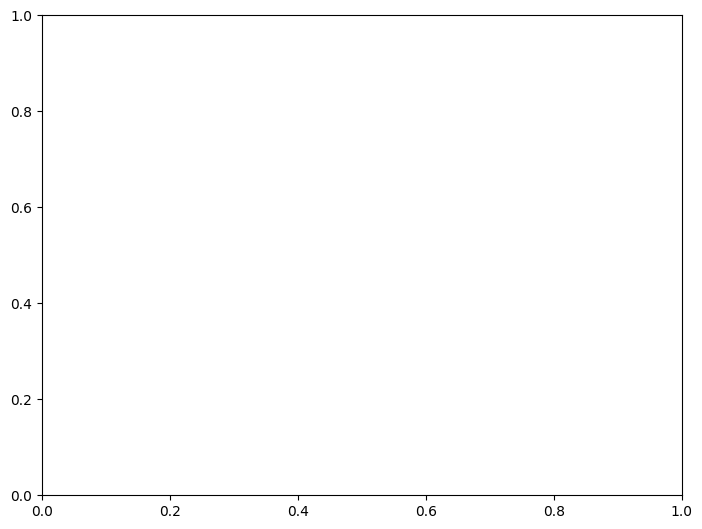

In [4]:
for subject in subjects: 
    maps_names = []
    volumes = {}
    exec('{}_volumes = {{}}'.format(re.sub('-','_',subject)))
    for task in tasks:
        
        print(task)
        
        # Define and create folder
        fit_dir = '{}/{}/prf/fit'.format(pp_dir, subject)
        mask_dir = '{}/{}/masks'.format(pp_dir, subject)
        flatmaps_dir = '{}/{}/prf/flatmaps'.format(pp_dir, subject)
        ref_index_dir = '{}/{}/prf/ref_index'.format(pp_dir, subject)
        try: os.makedirs(flatmaps_dir) 
        except: pass
    
        # load pRF threshold masks
        th_fn = '{}/{}_task-FullScreen_prf_threshold.nii.gz'.format(mask_dir,subject,task)
        th_mat = nb.load(th_fn).get_fdata()
        th_mat[np.isnan(th_mat)] = 0 # replace it by 0 for alpha maps

        # load ROIs masks
        rois_fn = '{}/ROIS_cortical.nii.gz'.format(mask_dir)
        rois_mat = nb.load(rois_fn).get_fdata()
        rois_opacity = 0.8
        rois_alpha_mat = rois_mat * 0 + rois_opacity
        rois_alpha_mat[rois_mat==0] = 0

        # Load fit parameters
        r2_im = nb.load('{}/{}_task-{}_par-r2.nii.gz'.format(fit_dir,subject,task))
        ecc_im = nb.load('{}/{}_task-{}_par-ecc.nii.gz'.format(fit_dir,subject,task))
        sd_im = nb.load('{}/{}_task-{}_par-sd.nii.gz'.format(fit_dir,subject,task))
        amp_im = nb.load('{}/{}_task-{}_par-amplitude.nii.gz'.format(fit_dir,subject,task))
        x_im = nb.load('{}/{}_task-{}_par-x.nii.gz'.format(fit_dir,subject,task))
        y_im = nb.load('{}/{}_task-{}_par-y.nii.gz'.format(fit_dir,subject,task))

        # Create param matrix
        r2_idx, ecc_idx, sd_idx, amp_idx, x_idx, y_idx = 0, 1, 2, 3, 4, 5
        param_mat = np.zeros((r2_im.shape[0],r2_im.shape[1],r2_im.shape[2],6))*np.nan
        param_mat[...,r2_idx] = r2_im.get_fdata()*th_mat # mask it by pRF threshold
        param_mat[...,ecc_idx] = ecc_im.get_fdata()
        param_mat[...,sd_idx] = sd_im.get_fdata()
        param_mat[...,amp_idx] = amp_im.get_fdata()
        param_mat[...,x_idx] = x_im.get_fdata()
        param_mat[...,y_idx] = y_im.get_fdata()

        # get R2 across tasks
        if task == 'FullScreenAttendFix': 
            r2_attend_mat = np.zeros((r2_im.shape[0],r2_im.shape[1],r2_im.shape[2],2))*np.nan
            r2_attend_mat[...,0] = param_mat[...,r2_idx]
        elif task == 'FullScreenAttendBar': 
            r2_attend_mat[...,1] = param_mat[...,r2_idx]

        # # Define ROIs
        # if task == 'FullScreen':
        #     rois_param = {'data': rois_mat+1.1, 'cmap': roi, 'alpha': rois_alpha_mat, 'vmin': rois_range[0], 'vmax': rois_range[1], 'cmap_steps': rois_range[1], 
        #                  'cbar': 'discrete','roi_name': 'pRF_rois','description': '{}: pRF ROIs'.format(task), 'curv_brightness': 1, 
        #                  'curv_contrast': 0.3, 'add_roi': save_svg, 'subject': subject, 'xfmname': xfm_name}
        #     exec('{}_rois_param = rois_param'.format(task))
        #     maps_names.append('{}_rois'.format(task))

        # Define pRF R2
        r2_data = param_mat[...,r2_idx]
        alpha = (r2_data - alpha_range[0])/(alpha_range[1]-alpha_range[0])
        alpha[alpha>1]=1
        r2_param = {'data': param_mat[...,r2_idx], 'cmap': cmap_uni, 'alpha': alpha, 'vmin': r2_range[0],'vmax': r2_range[1],
                    'cbar': 'discrete', 'cbar_label': 'R2', 'description': '{}: pRF R2'.format(task), 'curv_brightness': 1, 
                    'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}
        exec('{}_r2_param = r2_param'.format(task))
        # maps_names.append('{}_r2'.format(task))
        
        # # Define pRF eccentricity
        # ecc_data = param_mat[...,ecc_idx]
        # ecc_param = {'data': ecc_data, 'cmap': cmap_ecc_size, 'alpha': alpha, 'vmin': ecc_range[0], 'vmax': ecc_range[1],
        #              'cbar': 'ecc','roi_name': 'pRF_eccentricity','description': '{}: pRF eccentricity'.format(task), 'curv_brightness': 1, 
        #              'curv_contrast': 0.3, 'add_roi': save_svg, 'subject': subject, 'xfmname': xfm_name}
        # exec('{}_ecc_param = ecc_param'.format(task))
        # maps_names.append('{}_ecc'.format(task))
        
        # # Define pRF polar angle
        # pol_comp_num = param_mat[...,x_idx] + 1j * param_mat[...,y_idx]
        # polar_ang = np.angle(pol_comp_num)
        # ang_norm = (polar_ang + np.pi) / (np.pi * 2.0)
        # ang_norm = np.fmod(ang_norm + col_offset,1)
        # polar_param = {'data': ang_norm, 'cmap': cmap_polar, 'alpha': alpha, 'vmin': 0, 'vmax': 1, 'cmap_steps': cmap_steps, 
        #                'cbar': 'polar', 'roi_name': 'pRF_polar_angle', 'col_offset': col_offset, 'description': '{}: pRF polar angle'.format(task), 
        #                'curv_brightness': 0.1, 'curv_contrast': 0.25, 'add_roi': save_svg, 'subject': subject, 'xfmname': xfm_name}
        # exec('{}_polar_param = polar_param'.format(task))
        # maps_names.append('{}_polar'.format(task))
        
        # # Define pRF size
        # size_data = param_mat[...,sd_idx]
        # size_param = {'data': size_data, 'cmap': cmap_ecc_size, 'alpha': alpha, 'vmin': size_range[0], 'vmax': size_range[1], 
        #               'cbar': 'discrete', 'cbar_label': 'pRF size (dva)', 'description': '{}: pRF size'.format(task), 'curv_brightness': 1, 
        #               'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}
        # exec('{}_size_param = size_param'.format(task))
        # maps_names.append('{}_size'.format(task))
        
        # Define R2 attention comparison
        if task == 'FullScreen':
            attcmp_param = {'data':  r2_attend_mat[...,0], 'alpha': r2_attend_mat[...,1], 'cmap': cmap_2d, 'vmin': [r2_2d_range[0],r2_2d_range[0]],
                            'vmax': [r2_2d_range[1],r2_2d_range[1]], 'cortex_type': 'Volume2D', 'cbar': '2D', 'add_roi': False,
                            'description': 'FullScreen: AttendFix vs. AttendBar', 'curv_brightness': 1, 'curv_contrast': 0.3,
                            'cbar_label': ['AttendFix','AttendBar'], 'subject': subject, 'xfmname': xfm_name}
            exec('{}_attcmp_param = attcmp_param'.format(task))
            maps_names.append('{}_attcmp'.format(task))
           
        # Refit reference frame index
        if task == 'FullScreen':
            ab_ref_index_data = nb.load('{}/{}_task-AttendBar_refit_ref_index.nii.gz'.format(ref_index_dir,subject)).get_fdata()
            AttendBar_ref_index_param = {'data': ab_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
                                  'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendBar: Reference frame index'.format(task), 
                                  'curv_brightness': 1, 'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}
            exec('{}_size_param = AttendBar_ref_index_param'.format(task))
            maps_names.append('AttendBar_ref_index')
            
            af_ref_index_data = nb.load('{}/{}_task-AttendFix_refit_ref_index.nii.gz'.format(ref_index_dir,subject)).get_fdata()
            AttendFix_ref_index_param = {'data': af_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
                                  'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendFix: Reference frame index'.format(task), 
                                  'curv_brightness': 1, 'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}
            exec('{}_size_param = AttendFix_ref_index_param'.format(task))
            maps_names.append('AttendFix_ref_index')

    # Flatmaps
    for maps_name in maps_names:
        exec('{}_volume, fig = draw_cortex(**{}_param)'.format(maps_name,maps_name))
        print("{}_task-{}".format(subject, maps_name))
        exec("plt.savefig('{}/{}_task-{}.pdf')".format(flatmaps_dir, subject, maps_name))
        plt.show()
        exec('vol_description = {}_param["description"]'.format(maps_name))
        exec('volume = {}_volume'.format(maps_name))
        volumes.update({vol_description:volume})

    # Save Webgl
    webgl_dir = '{}/derivatives/webgl_data/{}/'.format(base_dir, subject)
    if os.path.exists(webgl_dir):
        print('deleting old : {}'.format(webgl_dir))
        shutil.rmtree(webgl_dir)
    print('saving: {}'.format(webgl_dir))
    try: os.makedirs(webgl_dir)
    except: pass
    cortex.webgl.make_static(outpath=webgl_dir, data=volumes, recache=recache, title=subject)
    
    # # Volumes for inflated brains
    # for maps_name in inflated_maps_names:
    #     exec('{}_volume, fig = draw_cortex(**{}_param)'.format(maps_name,maps_name))
    #     exec('vol_description = {}_param["description"]'.format(maps_name))
    #     exec('volume = {}_volume'.format(maps_name))
    #     exec('{}_volumes.update({{vol_description:volume}})'.format(re.sub('-','_',subject)))

In [ ]:
# Webgl for inflated brain pictures
subject2plot = 'sub-005'
inflated_dir = '{}/{}/prf/inflated'.format(pp_dir, subject2plot)
try: os.makedirs(inflated_dir) 
except: pass
port_num = 25971 # open on invibe server
print("Command to type on local terminal...")
print("ssh -Y -fN -L localhost:{}:localhost:{} admin@invibe.nohost.me".format(port_num,port_num))
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
exec('handle = cortex.webgl.show(data={}_volumes,recache = False, port=port_num, title=subject2plot, labels_visible=[])'.format(re.sub('-','_',subject2plot)))

In [ ]:
# general settings
inflated_general = {'camera.azimuth':225,
                    'camera.altitude':70,
                    'camera.radius':324,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':33,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.5,
                    'surface.{subject}.specularity':0.2,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':0.1}
handle._set_view(**inflated_general)
time.sleep(5)

In [ ]:
handle.setData(['FullScreen: pRF polar angle'])
time.sleep(5)
im1 = handle.getImage('{}/{}_inflated_polar.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.setData(['FullScreen: AttendFix vs. AttendBar'])
time.sleep(5)
inflated_attcmp = { 'surface.{subject}.colorbar':False}
handle._set_view(**inflated_attcmp)
time.sleep(5)
im2 = handle.getImage('{}/{}_inflated_attcmp.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.setData(['FullScreen: pRF eccentricity'])
time.sleep(5)
# inflated_ecc = {'surface.{subject}.curvature.brightness':0.6}
# handle._set_view(**inflated_ecc)
time.sleep(5)
#im3 = handle.getImage('{}/{}_inflated_ecc.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.setData(['AttendBar: Reference frame index'])
time.sleep(5)
inflated_ab_ref_index = {'surface.{subject}.curvature.brightness':0.9,
                   'surface.{subject}.curvature.contrast':0.1}
handle._set_view(**inflated_ab_ref_index)
time.sleep(5)
im4 = handle.getImage('{}/{}_inflated_ab_ref_index.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.setData(['AttendFix: Reference frame index'])
time.sleep(5)
im5 = handle.getImage('{}/{}_inflated_af_ref_index.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.close()

In [ ]:
# for angle and eccentricity

# pick right settings as in figure
# put opacity to 0
# Make video rotation unfolded depth at 0
# make inflation no pivot
# change depth to 0.5
# Make video with change opacity from 0-1
# Make video with flattenning
# put ROIS lines and labels
# put back to inflated, put labels ROIS



#### make demo video

In [ ]:
# Webgl for inflated brain pictures
subject2plot = 'sub-003'
inflated_dir = '{}/{}/prf/inflated'.format(pp_dir, subject2plot)
try: os.makedirs(inflated_dir) 
except: pass
port_num = 25971 # open on invibe server
print("Command to type on local terminal...")
print("ssh -Y -fN -L localhost:{}:localhost:{} admin@invibe.nohost.me".format(port_num,port_num))
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
exec('handle = cortex.webgl.show(data={}_volumes,recache = False, port=port_num, title=subject2plot, labels_visible=[])'.format(re.sub('-','_',subject2plot)))


In [ ]:
# pRF angle video
num=0
im_size=(800, 800)
par2plot='pRFecc'
inflated_vid_dir = '{}/{}/prf/video/{}/'.format(pp_dir, subject2plot, par2plot)
try: os.makedirs(inflated_vid_dir)
except: pass

# general settings
inflated_general = {'camera.azimuth':225,
                    'camera.altitude':70,
                    'camera.radius':324,
                    'surface.{subject}.unfold':0,
                    'surface.{subject}.pivot':0,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.0,
                    'surface.{subject}.specularity':0.2,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.opacity':0.0,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.4,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':0.1}
handle._set_view(**inflated_general)
time.sleep(5)

# get pRF angle
if par2plot == 'pRFangle':
    handle.setData(['FullScreen: pRF polar angle'])
elif par2plot == 'pRFecc':
    handle.setData(['FullScreen: pRF eccentricity'])


# make azimuth rotation
print("make azimuth rotation")
for azimuth_val in np.arange(0,226,5):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        azimuth = { 'camera.azimuth':azimuth_val}
        handle._set_view(**azimuth)
        im = handle.getImage(filename=fn, size=im_size)

azimuth = {'camera.azimuth': azimuth_val}
handle._set_view(**azimuth)
        
# make unfold to inflated
print("make unfold to inflated")
for unfold_val in np.arange(0,0.51,0.01):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        unfold = {'surface.{subject}.unfold':unfold_val}
        handle._set_view(**unfold)
        im = handle.getImage(filename=fn, size=im_size)
        
unfold = {'surface.{subject}.unfold':unfold_val}
handle._set_view(**unfold)

# change depth
depth = {'surface.{subject}.depth':0.5}
handle._set_view(**depth)
time.sleep(1)
         
# change opacity
print("change opacity")
for opacity_val in np.arange(0,1.1,0.1):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        opacity = {'surface.{subject}.opacity':opacity_val}
        handle._set_view(**opacity)
        im = handle.getImage(filename=fn, size=im_size)    

opacity = {'surface.{subject}.opacity':opacity_val}
handle._set_view(**opacity)

# make unfold to flatten
print("make unfold to flatten")
for unfold_val in np.arange(0.50,1.01,0.01):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        unfold = {'surface.{subject}.unfold':unfold_val}
        handle._set_view(**unfold)
        im = handle.getImage(filename=fn, size=im_size) 
unfold = {'surface.{subject}.unfold':unfold_val}
handle._set_view(**unfold)


In [ ]:
# put roi manualy
num += 1
fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                           par=par2plot, num=num)
if os.path.exists(fn)==False:
    im = handle.getImage(filename=fn, size=im_size) 

In [ ]:
# fold to inflated
print("fold to inflated")
for unfold_val in np.arange(1,0.49,-0.01):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        unfold = {'surface.{subject}.unfold': unfold_val}
        handle._set_view(**unfold)
        im = handle.getImage(filename=fn, size=im_size) 

unfold = {'surface.{subject}.unfold': unfold_val}
handle._set_view(**unfold)
        
# pivot to show lateral 
print("pivot to show lateral")
for pivot_val in np.arange(0,34,1):
    num += 1
    fn = '{folder}/{subject}_video_{par}_{num:02d}.png'.format(folder=inflated_vid_dir, subject=subject2plot,
                                                               par=par2plot, num=num)
    if os.path.exists(fn)==False:
        pivot = {'surface.{subject}.pivot': pivot_val}
        handle._set_view(**pivot)
        im = handle.getImage(filename=fn, size=im_size) 

pivot = {'surface.{subject}.pivot': pivot_val}
handle._set_view(**pivot)

In [ ]:
# to make video
# 1. go to https://ezgif.com/ 
# 2. choose make gif >> upload images
# 3. upload images
# 4. choose 0 as "Delay time"
# 5. choose don't stack frames
# 6. accelerate by 15%
# 7. save as gif
# 3. choose convert to video
# 4. save as mp4

#### Make zoom on ROIs

In [ ]:
# Imports
import os
import numpy as np
import nibabel as nb
import shutil
import warnings
import cortex
import re
import time
import matplotlib.pyplot as plt
from pycortex_utils import draw_cortex
from pathlib import Path
warnings.filterwarnings('ignore')

In [ ]:
# General settings
subject = 'sub-005'
xfm_name = 'identity.fmriprep'
task = 'FullScreen'

base_dir = '/home/mszinte/disks/meso_S/data/gaze_prf'
bids_dir = "{}".format(base_dir)
pp_dir = "{}/derivatives/pp_data".format(base_dir)
fit_dir = '{}/{}/prf/fit'.format(pp_dir, subject)
mask_dir = '{}/{}/masks'.format(pp_dir, subject)
flatmaps_dir = '{}/{}/prf/flatmaps'.format(pp_dir, subject)
ref_index_dir = '{}/{}/prf/ref_index'.format(pp_dir, subject)
pycortex_dir = "{}/cortex".format(pp_dir)

# Write pycortex config file
pycortex_db = "{}/db/".format(pycortex_dir)
pycortex_cm = "{}/colormaps/".format(pycortex_dir)
pycortex_config_file  = cortex.options.usercfg
pycortex_config_file_new = pycortex_config_file[:-4] + '_new.cfg'
pycortex_config_file_old = pycortex_config_file[:-4] + '_old.cfg'

Path(pycortex_config_file_new).touch()
with open(pycortex_config_file, 'r') as fileIn:
    with open(pycortex_config_file_new, 'w') as fileOut:
        for line in fileIn:
            if 'filestore' in line:
                newline = 'filestore=' + pycortex_db
                fileOut.write(newline)
                newline = '\n'
            elif 'colormaps' in line:
                newline = 'colormaps=' + pycortex_cm
                fileOut.write(newline)
                newline = '\n'
            else:
                newline = line
            fileOut.write(newline)
os.rename(pycortex_config_file,pycortex_config_file_old)
os.rename(pycortex_config_file_new, pycortex_config_file)

In [ ]:
# Load pRF threshold masks
th_fn = '{}/{}_task-FullScreen_prf_threshold.nii.gz'.format(mask_dir,subject,task)
th_mat = nb.load(th_fn).get_fdata()
th_mat[np.isnan(th_mat)] = 0 # replace it by 0 for alpha maps

# Load fit parameters
r2_im = nb.load('{}/{}_task-{}_par-r2.nii.gz'.format(fit_dir,subject,task))
ecc_im = nb.load('{}/{}_task-{}_par-ecc.nii.gz'.format(fit_dir,subject,task))
sd_im = nb.load('{}/{}_task-{}_par-sd.nii.gz'.format(fit_dir,subject,task))
amp_im = nb.load('{}/{}_task-{}_par-amplitude.nii.gz'.format(fit_dir,subject,task))
x_im = nb.load('{}/{}_task-{}_par-x.nii.gz'.format(fit_dir,subject,task))
y_im = nb.load('{}/{}_task-{}_par-y.nii.gz'.format(fit_dir,subject,task))

# Create param matrix
r2_idx, ecc_idx, sd_idx, amp_idx, x_idx, y_idx = 0, 1, 2, 3, 4, 5
param_mat = np.zeros((r2_im.shape[0],r2_im.shape[1],r2_im.shape[2],6))*np.nan
param_mat[...,r2_idx] = r2_im.get_fdata()*th_mat # mask it by pRF threshold
param_mat[...,ecc_idx] = ecc_im.get_fdata()
param_mat[...,sd_idx] = sd_im.get_fdata()
param_mat[...,amp_idx] = amp_im.get_fdata()
param_mat[...,x_idx] = x_im.get_fdata()
param_mat[...,y_idx] = y_im.get_fdata()

# range
alpha_range = [0, 0.4]
ref_index_range = [-0.4,0.4]

# cmap
cmap_ref_index = 'RdBu_r'

# Define alpha map
r2_data = param_mat[...,r2_idx]
alpha = (r2_data - alpha_range[0])/(alpha_range[1]-alpha_range[0])
alpha[alpha>1]=1

maps_names = []
volumes = {}

zoom_rois = ['V1', 'hMT+']
zoom_roi_hemis  = ['left', 'right']

ab_ref_index_data = nb.load('{}/{}_task-AttendBar_refit_ref_index.nii.gz'.format(ref_index_dir, subject)).get_fdata()
af_ref_index_data = nb.load('{}/{}_task-AttendFix_refit_ref_index.nii.gz'.format(ref_index_dir, subject)).get_fdata()

# # Small zoom maps
# for zoom_roi_num, zoom_roi in enumerate(zoom_rois):
#     for zoom_roi_hemi in zoom_roi_hemis:
        
#         AttendBar_ref_index_param = {'data': ab_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
#                                      'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendBar: Reference frame index', 
#                                      'curv_brightness': 1, 'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name, 
#                                      'zoom_to_roi': True, 'zoom_roi': zoom_roi, 'zoom_roi_hemi': zoom_roi_hemi}

#         exec('roi{}_{}_AttendBar_ref_index_param = AttendBar_ref_index_param'.format(zoom_roi_num, zoom_roi_hemi))
#         maps_names.append('roi{}_{}_AttendBar_ref_index'.format(zoom_roi_num, zoom_roi_hemi))

#         AttendFix_ref_index_param = {'data': af_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
#                                      'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendFix: Reference frame index', 
#                                      'curv_brightness': 1, 'curv_contrast': 0.3, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name,
#                                      'zoom_to_roi': True, 'zoom_roi': zoom_roi, 'zoom_roi_hemi': zoom_roi_hemi}
#         exec('roi{}_{}_AttendFix_ref_index_param = AttendFix_ref_index_param'.format(zoom_roi_num, zoom_roi_hemi))
#         maps_names.append('roi{}_{}_AttendFix_ref_index'.format(zoom_roi_num, zoom_roi_hemi))
        
        
# Full flatmaps
AttendBar_ref_index_param = {'data': ab_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
                             'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendBar: Reference frame index', 
                             'curv_brightness': 0.9, 'curv_contrast': 0.1, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}

maps_names.append('AttendBar_ref_index')

AttendFix_ref_index_param = {'data': af_ref_index_data, 'cmap': cmap_ref_index, 'alpha': alpha, 'vmin': ref_index_range[0], 'vmax': ref_index_range[1], 
                             'cbar': 'discrete', 'cbar_label': 'Reference frame index (a.u.)', 'description': 'AttendFix: Reference frame index', 
                             'curv_brightness': 0.9, 'curv_contrast': 0.1, 'add_roi': False, 'subject': subject, 'xfmname': xfm_name}
maps_names.append('AttendFix_ref_index')

In [ ]:
for maps_name in maps_names:
    exec('{}_volume, fig = draw_cortex(**{}_param)'.format(maps_name,maps_name))
    print("{}_task-{}".format(subject, maps_name))
    exec("plt.savefig('{}/{}_task-{}.pdf')".format(flatmaps_dir, subject, maps_name))
    print('{}/{}_task-{}.pdf'.format(flatmaps_dir, subject, maps_name))
    plt.show()
    
    exec('vol_description = {}_param["description"]'.format(maps_name))
    exec('volume = {}_volume'.format(maps_name))
    volumes.update({vol_description:volume})
    

In [ ]:
# Webgl for inflated brain pictures
subject2plot = 'sub-005'
flatmaps_dir = '{}/{}/prf/flatmaps'.format(pp_dir, subject2plot)
flatmaps_dir = '{}/{}/prf/flatmaps'.format(pp_dir, subject2plot)
try: os.makedirs(inflated_dir) 
except: pass
port_num = 25971 # open on invibe server
print("Command to type on local terminal...")
print("ssh -Y -fN -L localhost:{}:localhost:{} admin@invibe.nohost.me".format(port_num,port_num))
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
exec('handle = cortex.webgl.show(data=volumes,recache = False, port=port_num, title=subject2plot, labels_visible=[])'.format(re.sub('-','_',subject2plot)))


In [ ]:
# general settings
rfi_general = { 'surface.{subject}.unfold':1,
                'surface.{subject}.left':True,
                'surface.{subject}.right':True,
                'surface.{subject}.depth':0.5,
                'surface.{subject}.specularity':0,
                'surface.{subject}.layers':32,
                'surface.{subject}.dither':False,
                'surface.{subject}.colorbar':False,
                'surface.{subject}.sampler':'nearest',
                'surface.{subject}.curvature.brightness':0.9,
                'surface.{subject}.curvature.contrast':0.3,
                'surface.{subject}.curvature.smoothness':0.2}
handle._set_view(**rfi_general)
time.sleep(5)

In [ ]:
handle.setData(['AttendBar: Reference frame index'])
time.sleep(5)
print('image save: {}/{}_flatten_ab_ref_index.png'.format(inflated_dir,subject2plot))
im1 = handle.getImage('{}/{}_flatten_ab_ref_index.png'.format(inflated_dir,subject2plot),size = (3000, 3000))

In [ ]:
handle.setData(['AttendFix: Reference frame index'])
time.sleep(5)
print('image save: {}/{}_flatten_af_ref_index.png'.format(inflated_dir,subject2plot))
im2 = handle.getImage('{}/{}_flatten_af_ref_index.png'.format(inflated_dir,subject2plot),size = (3000, 3000))